In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'dataset/heart.h5ad'
# the heart data is downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE121893
# in R,
# do
# dat <- read.csv('GSE121893_human_heart_sc_umi.csv.gz', row.names = 1)
# library(Matrix)
# dat <- as(as.matrix(dat), "sparseMatrix")  
# library(reticulate)
# sc = import("scanpy")
# info = read.delim('GSE121893_human_heart_sc_info.txt.gz', skip = 15, row.names = 1)
# adata = sc$AnnData(Matrix::t(dat), obs = info, var = data.frame(row.names(dat), gene_id = row.names(dat)))
# adata$write('heart.h5ad', compression = 'gzip')

adata = sc.read_h5ad(results_file)
adata

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 4933 × 25742 
    obs: 'Barcode', 'Type', 'Individual', 'Age', 'Gender', 'Dispense.Order', 'X384.Well.Plate.Location', 'Chip.Row.ID', 'Chip.Column.ID', 'Image.ID', 'Barcode.Read.Pairs', 'Distinct.UMIs', 'ERCC.Read.Pairs', 'Trimmed.Read.Pairs', 'NoContam.Read.Pairs', 'Mitochondria.Alignments', 'Mitochondria.Read.Pairs', 'Total.Barcode.Alignments', 'Distinct.Genes.w..Alignments', 'Distinct.Gene.UMI.Combos', 'Aligned', 'Assigned', 'Ambiguity', 'Chimera', 'Duplicate', 'FragementLength', 'MappingQuality', 'MultiMapping', 'NoFeatures', 'Nonjunction', 'Secondary', 'Unmapped', 'mito.perc', 'CellType'
    var: 'gene_id'

normalizing counts per cell
    finished (0:00:00)


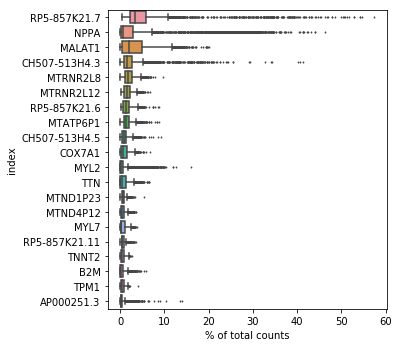

In [8]:
# looks like only the raw data is provided. so i can reanalyse from scratch
# continue with the standard analysis first
sc.settings.verbosity = 3
# plot higest expr genes
sc.pl.highest_expr_genes(adata, n_top = 20)

In [9]:
# get mitochondria QC stats
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis = 1) / np.sum(adata.X, axis = 1)
adata.obs['n_counts'] = adata.X.sum(axis = 1)

In [10]:
# normalize matrix X to 10000 reads per cell
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
# Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. 
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


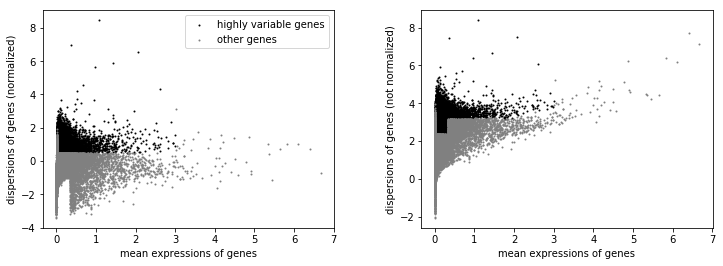

In [11]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
# plot highly_variable_genes
sc.pl.highly_variable_genes(adata)

In [12]:
s_genes = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
g2m_genes = ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [13]:
# Actually do the filtering.
adata = adata[:, adata.var['highly_variable']]

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


Trying to set attribute `.obs` of view, making a copy.
... storing 'phase' as categorical


    finished (0:01:38)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:07)


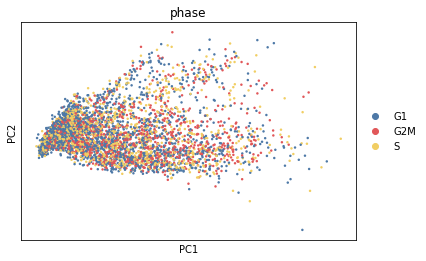

In [14]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pl.pca_scatter(adata, color=['phase'], palette = ['#4e79a7', '#e15759', '#f1ce63'])

regressing out ['n_counts', 'percent_mito', 'S_score', 'G2M_score']
    finished (0:01:18)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:11)


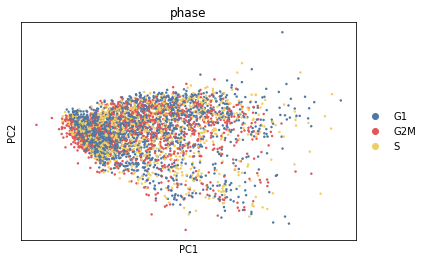

In [15]:
# regress and scale for PCA
sc.pp.regress_out(adata, ['n_counts', 'percent_mito', 'S_score', 'G2M_score'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pl.pca_scatter(adata, color=['phase'], palette = ['#4e79a7', '#e15759', '#f1ce63'])

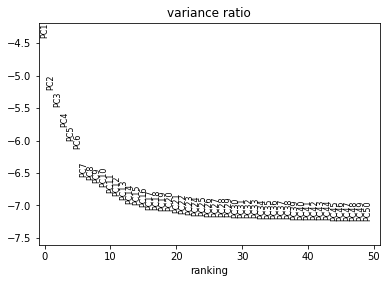

In [16]:
# Principal component analysis
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


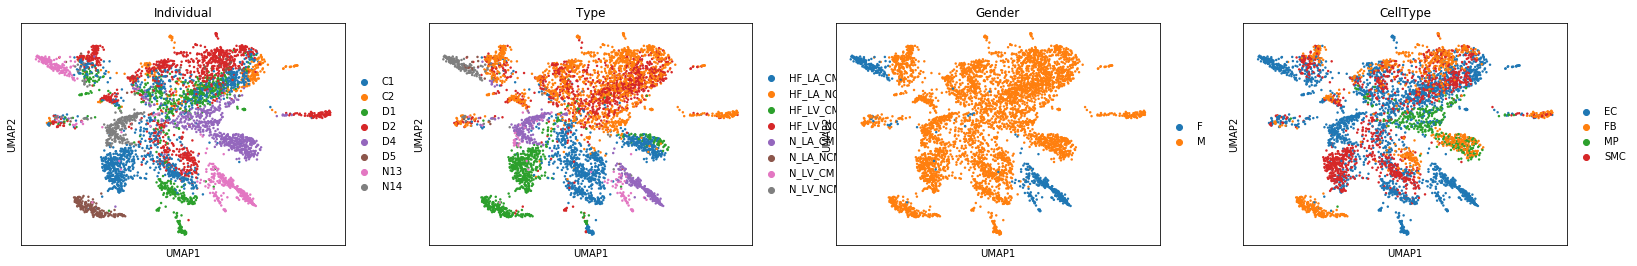

In [24]:
# Computing the neighborhood graph. Seurat uses k = 20 as default
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 50)
# run UMAP
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
# find clusters
sc.tl.leiden(adata)
# plotting groups and clusters
sc.pl.umap(adata, color = ['Individual', 'Type', 'Gender', 'CellType'])

In [25]:
# subset to just the macrophages
adata = adata[adata.obs['CellType'] == 'MP']
adata

View of AnnData object with n_obs × n_vars = 336 × 8345 
    obs: 'Barcode', 'Type', 'Individual', 'Age', 'Gender', 'Dispense.Order', 'X384.Well.Plate.Location', 'Chip.Row.ID', 'Chip.Column.ID', 'Image.ID', 'Barcode.Read.Pairs', 'Distinct.UMIs', 'ERCC.Read.Pairs', 'Trimmed.Read.Pairs', 'NoContam.Read.Pairs', 'Mitochondria.Alignments', 'Mitochondria.Read.Pairs', 'Total.Barcode.Alignments', 'Distinct.Genes.w..Alignments', 'Distinct.Gene.UMI.Combos', 'Aligned', 'Assigned', 'Ambiguity', 'Chimera', 'Duplicate', 'FragementLength', 'MappingQuality', 'MultiMapping', 'NoFeatures', 'Nonjunction', 'Secondary', 'Unmapped', 'mito.perc', 'CellType', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'batch'
    var: 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'phase_colors', 'neighbors', 'umap', 'leiden', 'Individual_colors', 'CellType_colors', 'leiden_colors', 'Type_colors', 'Gender_colors'
    obsm: 'X_pca', 'X_umap'
    var

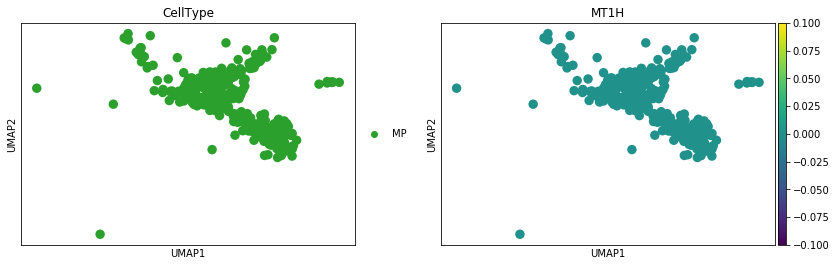

In [26]:
sc.pl.umap(adata, color = ['CellType', 'MT1H'])

In [27]:
# save first
adata.write('dataset/heart.h5ad', compression = 'gzip')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'dataset/heart.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 336 × 8345 
    obs: 'Barcode', 'Type', 'Individual', 'Age', 'Gender', 'Dispense.Order', 'X384.Well.Plate.Location', 'Chip.Row.ID', 'Chip.Column.ID', 'Image.ID', 'Barcode.Read.Pairs', 'Distinct.UMIs', 'ERCC.Read.Pairs', 'Trimmed.Read.Pairs', 'NoContam.Read.Pairs', 'Mitochondria.Alignments', 'Mitochondria.Read.Pairs', 'Total.Barcode.Alignments', 'Distinct.Genes.w..Alignments', 'Distinct.Gene.UMI.Combos', 'Aligned', 'Assigned', 'Ambiguity', 'Chimera', 'Duplicate', 'FragementLength', 'MappingQuality', 'MultiMapping', 'NoFeatures', 'Nonjunction', 'Secondary', 'Unmapped', 'mito.perc', 'CellType', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'batch', 'Mac1_score', 'Mac2_score', 'Mac-MT1_score', 'Mono_score', 'DC_score', 'Mac-cycling_score'
    var: 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellType_colors', 'Gender_colors', 'Individual_colors', 'Type_colors', 'leiden', 'leiden_colors', 'ne

In [2]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [3]:
# now compute Mac-MT1 score p-values. figure out the global median and mad (from above-median values) for the distribution for each celltype
med = np.median(adata.obs['Mac-MT1_score'])
mask = adata.obs['Mac-MT1_score']>med
mad = np.median(adata.obs['Mac-MT1_score'][mask]-med)
# do a one-sided test with Krystoff's implementation
pvals = 1-scipy.stats.norm.cdf(adata.obs['Mac-MT1_score'], loc=med, scale=1.4826*mad)
adata.obs['bh_pval'] = bh(pvals)

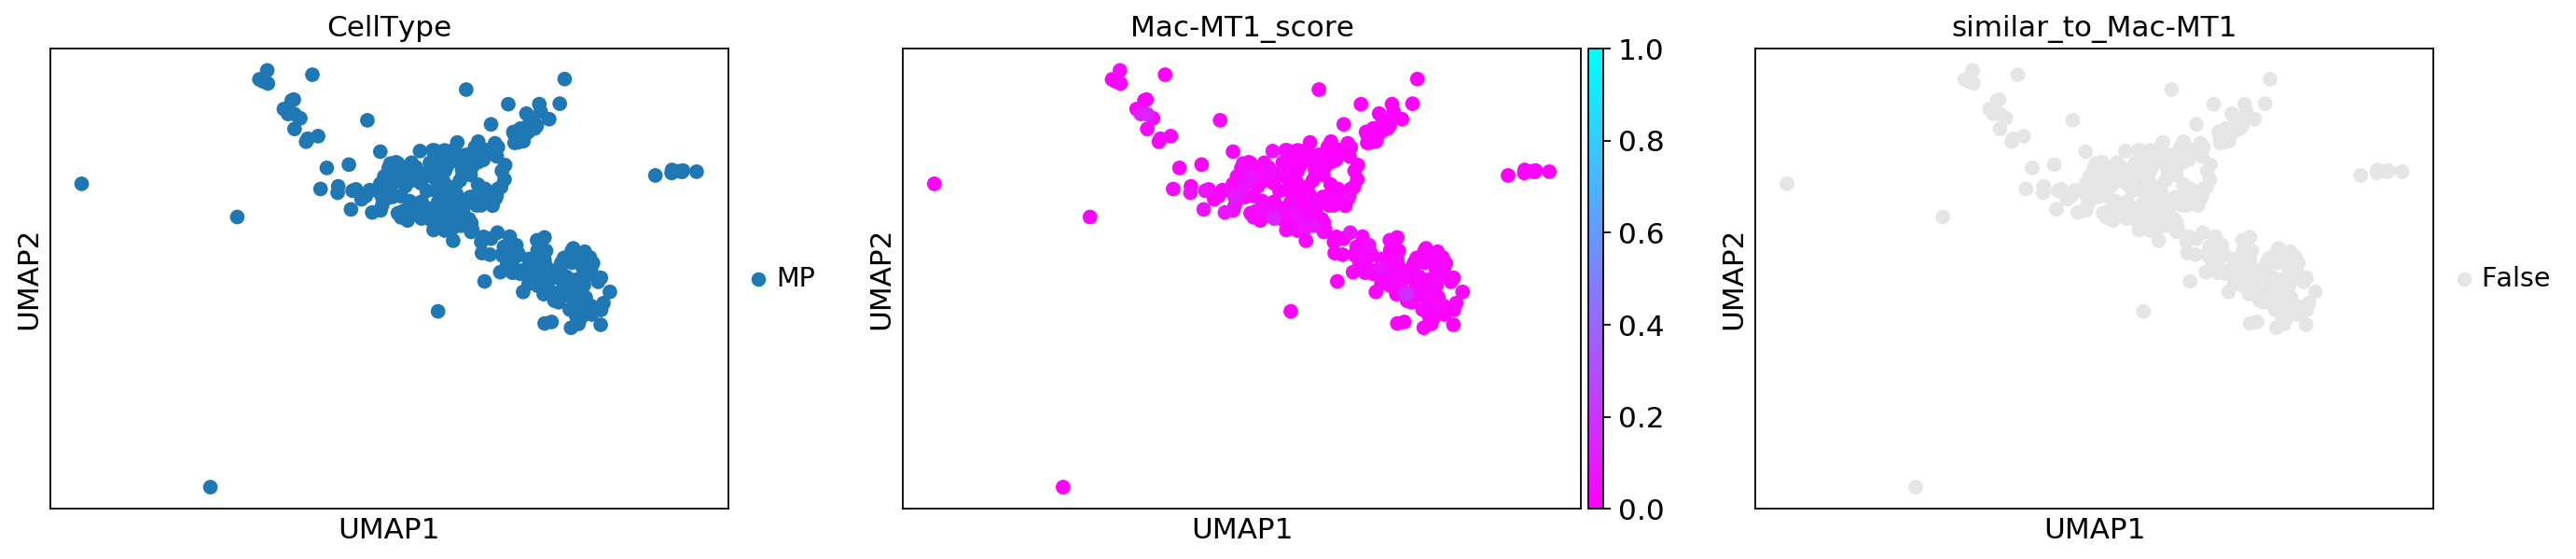

In [4]:
# threshold the p-values to get potential Mac-MT1 calls.
adata.obs['similar_to_Mac-MT1'] = (adata.obs['bh_pval'] < 0.05) & (adata.obs['Mac-MT1_score'] > 0.7)
adata.obs['similar_to_Mac-MT1'] = adata.obs['similar_to_Mac-MT1'].astype('category')
# visualise the Mac-MT1
adata.uns['similar_to_Mac-MT1_colors'] = ['#e5e5e5', '#e15759']
sc.set_figure_params(figsize = [6.0, 4.0], vector_friendly = True, dpi_save = 900)
sc.pl.umap(adata, color = ['CellType','Mac-MT1_score', 'similar_to_Mac-MT1'], size = 200, save = '/Heart_similarity_to_Mac-MT1.pdf', color_map = 'cool_r', vmax = 1)

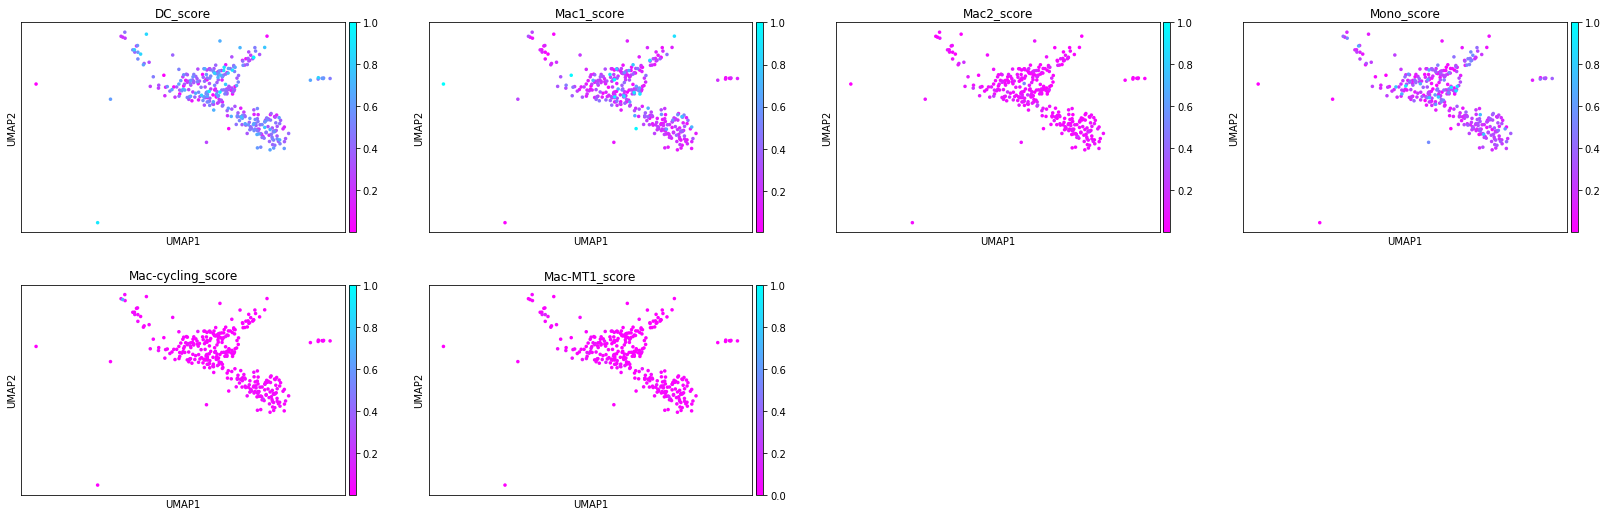

In [2]:
sc.pl.umap(adata, color = ['DC_score', 'Mac1_score', 'Mac2_score', 'Mono_score', 'Mac-cycling_score', 'Mac-MT1_score'], size =50, color_map = 'cool_r', vmax = 1)